### General Neural Network Structure

In [1]:
# define architecture
# take batch and do
#   * read image
#   * preprocess
#   * (optional) rotate, etc
#   * feed into NN
# train and show cost per epoch 
# test to show accuracy

### Import modules

In [2]:
%pylab inline

import os
import numpy as np
import pandas as pd
from scipy.misc import imread
from sklearn.metrics import accuracy_score

import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [3]:
# To stop potential randomness
seed = 128
rng = np.random.RandomState(seed)

### Set directory paths

In [4]:
root_dir = os.path.abspath('../..')
data_dir = os.path.join(root_dir, 'data')
sub_dir = os.path.join(root_dir, 'sub')

# check for existence
os.path.exists(root_dir)
os.path.exists(data_dir)
os.path.exists(sub_dir)

True

### Read files

In [5]:
train = pd.read_csv(os.path.join(data_dir, 'Train', 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'Test.csv'))

sample_submission = pd.read_csv(os.path.join(data_dir, 'Sample_Submission.csv'))

In [6]:
train.head()

,filename,label
0,0.png,4
1,1.png,9
2,2.png,1
3,3.png,7
4,4.png,3


In [7]:
test.head()

,filename
0,49000.png
1,49001.png
2,49002.png
3,49003.png
4,49004.png


In [8]:
sample_submission.head()

,filename,label


### Display a random image

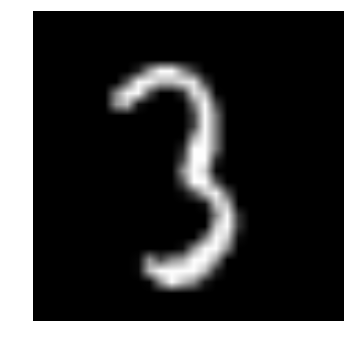

In [9]:
img_name = rng.choice(train.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)

img = imread(filepath, flatten=True)

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

### Convert all images to numpy arrays and stack them

In [10]:
temp = []
for img_name in train.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'train', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
train_x = np.stack(temp)

temp = []
for img_name in test.filename:
    image_path = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)
    img = imread(image_path, flatten=True)
    img = img.astype('float32')
    temp.append(img)
    
test_x = np.stack(temp)

In [11]:
split_size = int(train_x.shape[0]*0.7)

train_x, val_x = train_x[:split_size], train_x[split_size:]
train_y, val_y = train.label.ix[:split_size], train.label.ix[split_size:]

### Define helper functions

In [12]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors"""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    
    return labels_one_hot

def preproc(unclean_batch_x):
    """Convert values to range 0-1"""
    temp_batch = unclean_batch_x / unclean_batch_x.max()
    
    return temp_batch

def batch_creator(batch_size, dataset_length, dataset_name):
    """Create batch with random samples and return appropriate format"""
    batch_mask = rng.choice(dataset_length, batch_size)
    
    batch_x = eval(dataset_name + '_x')[[batch_mask]].reshape(-1, 784)
    batch_x = preproc(batch_x)
    
    if dataset_name == 'train':
        batch_y = eval(dataset_name).ix[batch_mask, 'label'].values
        batch_y = dense_to_one_hot(batch_y)
        
    return batch_x, batch_y

## Describe architecture

### Set variables

In [13]:
# number of neurons in each layer
input_num_units = 784
hidden_num_units = 500
output_num_units = 10

# define placeholders, i.e. way to feed values to computational graph
x = tf.placeholder(tf.float32, [None, input_num_units])
y = tf.placeholder(tf.float32, [None, output_num_units])

# set remaining variables
epochs = 5
batch_size = 128
learning_rate = 0.01

### Define weights and biases for nn

In [14]:
weights = {
    'hidden': tf.Variable(tf.random_normal([input_num_units, hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([hidden_num_units, output_num_units], seed=seed))
}

biases = {
    'hidden': tf.Variable(tf.random_normal([hidden_num_units], seed=seed)),
    'output': tf.Variable(tf.random_normal([output_num_units], seed=seed))
}

### Create computational graph

In [15]:
hidden_layer = tf.add(tf.matmul(x, weights['hidden']), biases['hidden'])
hidden_layer = tf.nn.relu(hidden_layer)

output_layer = tf.matmul(hidden_layer, weights['output']) + biases['output']

### Define cost

In [16]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(output_layer, y))

### Set optimizer viz. backpropogation algorithm to train NN

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

### Initialize variables

In [18]:
init = tf.initialize_all_variables()

### Create session and run

In [19]:
with tf.Session() as sess:
    # create initialized variables
    sess.run(init)
    
    ### for each epoch, do:
    ###   for each batch, do:
    ###     create pre-processed batch
    ###     run optimizer by feeding batch
    ###     find cost and reiterate to minimize
    
    
    for epoch in range(epochs):
        avg_cost = 0
        total_batch = int(train.shape[0]/batch_size)
        for i in range(total_batch):
            batch_x, batch_y = batch_creator(batch_size, train_x.shape[0], 'train')
            _, c = sess.run([optimizer, cost], feed_dict = {x: batch_x, y: batch_y})
            
            avg_cost += c / total_batch
            
        print "Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost)
    
    print "\nTraining complete!"
    
    
    # find predictions on val set
    pred_temp = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(pred_temp, "float"))
    print "Validation Accuracy:", accuracy.eval({x: val_x.reshape(-1, 784), y: dense_to_one_hot(val_y.values)})
    
    predict = tf.argmax(output_layer, 1)
    pred = predict.eval({x: test_x.reshape(-1, 784)})

Epoch: 1 cost = 8.93566
Epoch: 2 cost = 1.82103
Epoch: 3 cost = 0.98648
Epoch: 4 cost = 0.57141
Epoch: 5 cost = 0.44550

Training complete!
Validation Accuracy: 0.952823


Prediction is:  8


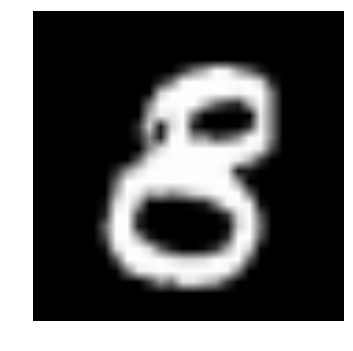

In [20]:
img_name = rng.choice(test.filename)
filepath = os.path.join(data_dir, 'Train', 'Images', 'test', img_name)

img = imread(filepath, flatten=True)

test_index = int(img_name.split('.')[0]) - 49000

print "Prediction is: ", pred[test_index]

pylab.imshow(img, cmap='gray')
pylab.axis('off')
pylab.show()

In [21]:
sample_submission.filename = test.filename; sample_submission.label = pred

In [22]:
sample_submission.to_csv(os.path.join(sub_dir, 'sub01.csv'), index=False)